In [1]:
from fmri.acquisitions import SparklingAcquisition
from fmri.reconstructors.base import SequentialFMRIReconstructor
from fmri.utils import ssos
from mri.operators import WaveletN 
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np

data_file = "/volatile/pierre-antoine/optimed/meas_MID36_2D_Sparkling_1mmiso0_3s_FID3362.dat"
bin_file = "/volatile/pierre-antoine/optimed/dim2_i_RadialIO_P0.75_N192x192_FOV0.192x0.192_Nc6_Ns2688_c30_d2__D7M9Y2021T160.bin"
shifts = np.array((-22,30.82343864))

acq = SparklingAcquisition(data_file,bin_file,frame_slicer=slice(0,2),calibrate=True)

pymapVBVD version 0.4.3
Software version: VB


Scan 1/1, read all mdhs:   0%|          | 0.00/15.4G [00:00<?, ?B/s]

.dat file red


read data:   0%|          | 0/12 [00:00<?, ?it/s]

kspace_data shape (13440, 32, 6, 2)
kspace_data shape (13440, 6, 32, 2)
kspace_data shape (6, 13440, 32, 2)
kspace_data shape (2, 32, 80640)
kspace_data imported
[192 192] (32, 161280) (161280, 2) (2,)


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   2 out of  32 | elapsed:    4.0s remaining:   59.9s
[Parallel(n_jobs=32)]: Done  32 out of  32 | elapsed:    4.4s finished


In [2]:
from pprint import pprint

# raw_img = acq._twix_obj.image[""]
# pprint(raw_img.shape)
pprint(acq._twix_obj.image)

pprint(acq._twix_obj.hdr['Phoenix'].get(('sWiPMemBlock','adFree','7'),0))
pprint(acq._twix_obj.hdr['Phoenix'].get(('sWiPMemBlock','adFree','8'),0))
pprint(acq._twix_obj.hdr['Phoenix'].get(('sWiPMemBlock','adFree','9'),0))

def add_phase_kspace(kspace_data, kspace_loc, shifts=None):
    if shifts is None:
        shifts = (0,) * kspace_loc.shape[1]
    if len(shifts) != kspace_loc.shape[1]:
        raise ValueError("Dimension mismatch between shift and kspace locations! "
                         "Ensure that shifts are right")
    phi = np.zeros_like(kspace_data)
    for i in range(kspace_loc.shape[1]):
        phi += kspace_loc[:, i] * shifts[i]
    phase = np.exp(-2 * np.pi * 1j * phi)
    return kspace_data * phase

***twix_map_obj***
File: /volatile/pierre-antoine/optimed/meas_MID36_2D_Sparkling_1mmiso0_3s_FID3362.dat
Software: vb
Number of acquisitions read 4800
Data size is [13440,   32,    6,    1,    1,    1,    1,    1,  800,    1,    1,    1,
     1,    1,    1,    1]
Squeezed data size is [13440,32,6,800] (['Col', 'Cha', 'Lin', 'Rep'])
NCol = 13440
NCha = 32
NLin  = 6
NAve  = 1
NSli  = 1
NPar  = 1
NEco  = 1
NPhs  = 1
NRep  = 800
NSet  = 1
NSeg  = 1
NIda  = 1
NIdb  = 1
NIdc  = 1
NIdd  = 1
NIde  = 1
-22.0
0
30.82343864


In [3]:
shifts = np.array((-22,30.82343864))
print(shifts)
k_data = acq.kspace_data
k_loc = acq.kspace_loc
k_data = add_phase_kspace(k_data,k_loc, shifts=shifts)[0]


k_data.shape, k_loc.shape, k_data.shape[1:],

[-22.          30.82343864]


((32, 80640), (80640, 2), (80640,))

In [4]:
from mri.operators import NonCartesianFFT
import matplotlib.pyplot as plt


In [5]:
fourier_gpuNUFFT = NonCartesianFFT(k_loc, acq.img_size, implementation='gpuNUFFT', n_coils=k_data.shape[0],osf=acq.OSF,smaps=acq.smaps)
fourier_pyNFFT = NonCartesianFFT(k_loc, acq.img_size, implementation='cpu', n_coils = k_data.shape[0], )


/home/pc266769/.pyenv/versions/3.6.13/envs/fmri/lib/python3.6/site-packages/mri/operators/fourier/non_cartesian.py:448: UserWarning: Samples will be normalized between [-0.5; 0.5[
  warnings.warn("Samples will be normalized between [-0.5; 0.5[")
/home/pc266769/.pyenv/versions/3.6.13/envs/fmri/lib/python3.6/site-packages/mri/operators/fourier/utils.py:106: UserWarning: Frequency equal to 0.5 will be put in -0.5
  warnings.warn("Frequency equal to 0.5 will be put in -0.5")
/home/pc266769/.pyenv/versions/3.6.13/envs/fmri/lib/python3.6/site-packages/mri/operators/fourier/non_cartesian.py:104: UserWarning: Samples will be normalized between [-0.5; 0.5[
  warnings.warn("Samples will be normalized between [-0.5; 0.5[")


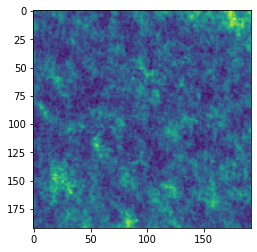

In [6]:
img_cpu = fourier_pyNFFT.adj_op(k_data)
img_cpu.shape


plt.figure()
plt.imshow(ssos(abs(img_cpu)))

TypeError: Invalid shape (192,) for image data

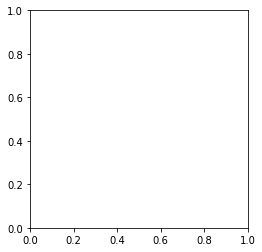

In [7]:
img_gpu = fourier_gpuNUFFT.adj_op(k_data)
img_gpu.shape


plt.figure()
plt.imshow(ssos(abs(img_gpu)))